# Experiments on the Nursery dataset

In this notebook we fully reproduce the experiments from the paper "Online Learning with Costly Features in Non-stationary Environments".

    
## Table Of Contents:
* [**1 Preparing the data**](#1-preparing-the-data)
    - [**1.1 Preprocessing nursery dataset**](#1-1-preprocessing-nursery)
    - [**1.2 Introducing reward non-stationarity**](#1-2-introducing-reward-non-stationarity)
    - [**1.3 Introducing feature costs**](#1-3-introducing-feature-costs)


* [**2 Evaluating bandit algorithms**](#2-evaluating-bandit-algorithms)


* [**3 Plotting figures**](#3-plotting-figures)
    - [**3.1 Regret**](#3-1-regret)
    - [**3.2 Reward-cost barchart**](#3-2-reward-cost-barchart)
    - [**3.3 Arm selection histogram**](#3-3-arm-selection-histogram)
    - [**3.4 Accuracy**](#3-4-accuracy)

### Import necessary libraries and modules

In [1]:
import os
os.chdir("../")

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

from src import algorithms, evaluation, costs, plotting, preprocessing

In [3]:
# Set random seed for reproducibility.
np.random.seed(42)

# 1 Preparing the data <a class="anchor" id="1-preparing-the-data"></a>



## 1.1 Preprocessing nursery dataset <a class="anchor" id="1-1-preprocessing-nursery"></a>

We preprocess the Nursery dataset to create a simulation environment for evaluating bandit algorithms. The environment has a time horizon $T$. At each time $t$ the environment draws a state (or context) vector $\phi_t$ of dimension $D$ and presents the agent with $A$ arms. The agent choses a subset of features $\phi[i]$ to observe, pays the correspond costs $c_t[i]$. After that the decision maker chooses one action $a_t$ and receives a reward $r_t$. 

**States:** In our experiment each $\phi_t$ is a row of the Nursery dataset. We set $D=5$ and chose 5 of the features of the original data. Namely, the columns `"form"`, `"children"`, `"finance"`, `"housing"` and `"health"`.

**Rewards:** Each arm corresponds to a nursery application class in the dataset. This is the column `"final evaluation"`. We set $A=3$ and only consider classes  `not recommended - (1)`, `priority_acceptance - (4)` and `special priority - (5)`, because classes `recommend - (2)` and `very recommend - (3)` are very rare and we don't want to have arms with very low mean rewards. Each of the three arms corresponds to one class. So at each time $t$ only one arm has reward 1 - the one corresponding to the correct class for the given row of the Nursery dataset.


Later, in section [**1.2 Introducing reward non-stationarity**](#1-2-introducing-reward-non-stationarity) we simulate a non-stationary reward generating process.

Costs are also introduced later, in section [**1.3 Introducing feature costs**](#1-3-introducing-feature-costs).

**Subsampling:** We use 10k points for evaluation. The remaining points were used to find the optimal hyperparameter values (not in this document). This notebook uses the tuned parameter values.

In [4]:
# This file was downloaded from here https://www.kaggle.com/datasets/heitornunes/nursery
# We provide it together with the repository.
csv_file = 'experiments/nursery/nursery.csv'

In [5]:
# Data only contains categorical features. 
df_num = pd.read_csv(csv_file, dtype='category')

In [6]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [7]:
# Make features have natural number ranges.
for colname in df_num:
    df_num[colname] = df_num[colname].cat.codes + 1

In [8]:
# Features are dropped according to their usefulness for the offline regression model.
# final evaluation is target variable
all_contexts = df_num.drop(['parents', 'has_nurs', 'social', 'social', 'final evaluation'], axis=1)

In [9]:
all_contexts

,form,children,housing,finance,health
0,1,1,1,1,2
1,1,1,1,1,3
2,1,1,1,1,1
3,1,1,1,1,2
4,1,1,1,1,3
...,...,...,...,...,...
12955,4,4,3,2,3
12956,4,4,3,2,1
12957,4,4,3,2,2
12958,4,4,3,2,3


In [10]:
y = df_num['final evaluation']

In [11]:
# Drop arms with small rewards

# Values meaning:
# not recommended (1)
# recommend (2)
# very recommend (3)
# priority acceptance (4)
# special priority (5)

all_contexts = all_contexts[(y != 3) & (y != 2)]

y = y[(y != 3) & (y != 2)]

In [12]:
# Create arms for bandit evaluation from y values.
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [13]:
# Split dataset into tuning and evaluation parts
TUNING_SIZE = 2630

tuning_idx = np.random.choice(a=all_contexts.shape[0], replace=False, size=TUNING_SIZE)
tuning_idx.sort()
tng_idx_set = set(tuning_idx)

evaluation_idx = np.array([i for i in range(all_contexts.shape[0]) if i not in tng_idx_set])

contexts_tuning = all_contexts.iloc[tuning_idx, :]
contexts_evaluation = all_contexts.iloc[evaluation_idx, :]

rewards_tuning = all_rewards[tuning_idx, :]
rewards_evaluation = all_rewards[evaluation_idx, :]

# Only use evaluation data
all_contexts = contexts_evaluation
all_rewards = rewards_evaluation

In [14]:
all_contexts

,form,children,housing,finance,health
2,1,1,1,1,1
4,1,1,1,1,3
6,1,1,1,1,2
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12952,4,4,3,2,3
12953,4,4,3,2,1
12955,4,4,3,2,3
12956,4,4,3,2,1


## 1.2 Introducing reward non-stationarity <a class="anchor" id="1-2-introducing-reward-non-stationarity"></a>

We simulate a non-stationary reward generating process by cyclically shifting class labels at designated change points.

At times $t = [1000, 2000, 5000, 8000]$ the class labels are shifted cyclically by some amount. This leads to a change in the underlying dependency between contexts and rewards. In the nursery application scenario this corresponds to a change in preferences of the authority over nursery applications (e.g. start to prefer kids from larger, rather then smaller families).


In [15]:
stationarity_regions = [
    slice(0, 1000),
    slice(1000, 2000),
    slice(2000, 5000),
    slice(5000, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [16]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [17]:
change_point_values

[1, 1000, 2000, 5000, 8000, 10000]

In [18]:
nonstationary_rewards = np.copy(all_rewards)
nonstationary_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(nonstationary_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        
        additional_shift = 0
        if i == 1 or i == 3:
            additional_shift = 1
        elif i == 2:
            additional_shift = 2
        
        # Cyclic shift of class labels
        arm_to = (arm_from + i + additional_shift) % n_arms
        if i > 0:
            nonstationary_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(nonstationary_rewards[region, arm_to].shape) * np.mean(nonstationary_rewards[region, arm_to])
        )

In [19]:
nonstationary_contexts.shape, nonstationary_rewards.shape

((10000, 5), (10000, 3))

# Plot expected reward before row exchanges

Here we plot sample mean of rewards of each arm (averaged over all contexts inside one stationary period).

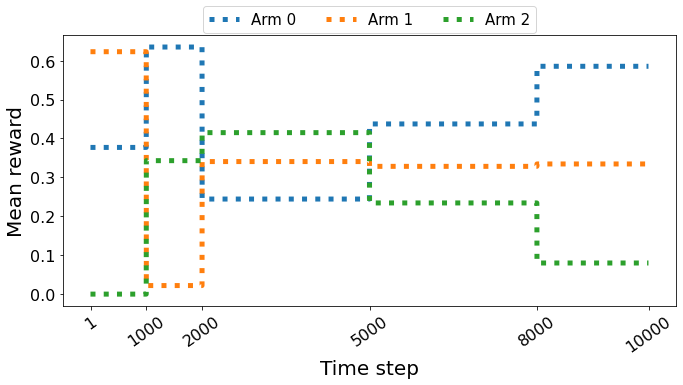

In [20]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm}", linestyle=':', linewidth=5)
    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(f"Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

plt.show()

## Exchange rows
Here we exchange rows between stationarity regions. We do this so that mean (averaged over all contexts) rewards of each arm have the following pattern: after each change point arm with best mean reward changes and the mean reward of the previous best drops significantly. The best arms change cyclically one by one.

#### How this works:
We take 2 arms: `arm_1` and `arm_2` and try to rebalance them between 2 stationarity regions `region_1` and `region_2`. We take a `percentage` of rows inside `region_1` where `arm_1` has reward 1 and exchange them with the same number of rows from `region_2` where `arm_2` has reward 1. \
In the nursery application ranking scenario this corresponds to applicants arriving in a different order.

In [21]:
arm_rebalancing_config = [
    {"arm_1": 1, "arm_2": 2, "region_1":2, "region_2":3, "percentage": 0.7},
    {"arm_1": 0, "arm_2": 1, "region_1":3, "region_2":4, "percentage": 0.6},
    {"arm_1": 2, "arm_2": 1, "region_1":1, "region_2":4, "percentage": 0.7},
    {"arm_1": 0, "arm_2": 1, "region_1":3, "region_2":1, "percentage": 0.7},
    {"arm_1": 0, "arm_2": 2, "region_1":2, "region_2":3, "percentage": 0.7},
    {"arm_1": 0, "arm_2": 1, "region_1":2, "region_2":4, "percentage": 0.8},
]

In [22]:
np.random.seed(42)

new_contexts, new_rewards = nonstationary_contexts, nonstationary_rewards

for arm_rebalance_params in arm_rebalancing_config:
    new_contexts, new_rewards = preprocessing.rebalance_arms_between_regions(
        contexts=new_contexts,
        rewards=new_rewards,
        stationarity_regions=stationarity_regions,
        arm_1=arm_rebalance_params["arm_1"], 
        arm_2=arm_rebalance_params["arm_2"], 
        region_1=arm_rebalance_params["region_1"], 
        region_2=arm_rebalance_params["region_2"], 
        percentage=arm_rebalance_params["percentage"], 
    )

## Plot expected reward after row exchanges

In [23]:
# compute mean rewards
mean_rewards = np.zeros(new_rewards.shape)
for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # For plotting
        mean_rewards[region, arm_from] = (
            np.ones(new_rewards[region, arm_from].shape) * np.mean(new_rewards[region, arm_from])
        )

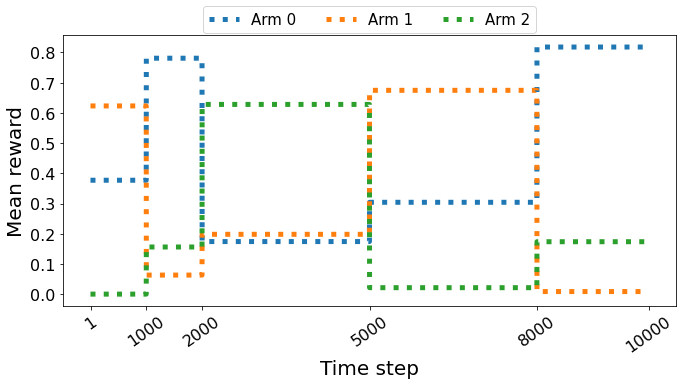

In [24]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm}", linestyle=':', linewidth=5)
#     print(f"Min expected reward for arm {arm}: {min(expected_gain)}")
    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel("Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.show()

## Validate the row exchange

Validate that no rows disappeared and now new rows appeared.

In [25]:
assert (np.sort(nonstationary_contexts, axis=0) == np.sort(new_contexts, axis=0)).all()

In [26]:
assert (np.sort(nonstationary_rewards, axis=0) == np.sort(new_rewards, axis=0)).all()

## 1.3 Introducing feature costs <a class="anchor" id="1-3-introducing-feature-costs"></a>

Here we create a vector of instantaneous costs of each feature for the full time horizon.

Costs of features are generated by a non-stationary process. Cost of each feature at time $t$ is sampled from a Gaussian distribution with $std=0.001$ and a piece-wise constant mean. At each of the change points $t=[1, 3000, 5000, 7000, 9000]$ a new mean is sampled from a uniform distribution over the interval $[0.03, 0.08]$. Below is a figure that depicts instanteneous costs of each feature for the full time horizon.

In [27]:
np.random.seed(42)

In [28]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

In [29]:
cost_means_range = [0.03, 0.08]
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [30]:
# Mean of gaussian distribution random in interval cost_means_range
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [31]:
interval_means

[array([0.04872701, 0.07753572, 0.0665997 , 0.05993292, 0.03780093]),
 array([0.03779973, 0.03290418, 0.07330881, 0.06005575, 0.06540363]),
 array([0.03102922, 0.07849549, 0.07162213, 0.04061696, 0.03909125]),
 array([0.03917023, 0.04521211, 0.05623782, 0.05159725, 0.04456146]),
 array([0.06059264, 0.03697469, 0.04460723, 0.04831809, 0.0528035 ])]

In [32]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [33]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

### Figure of costs of each feature

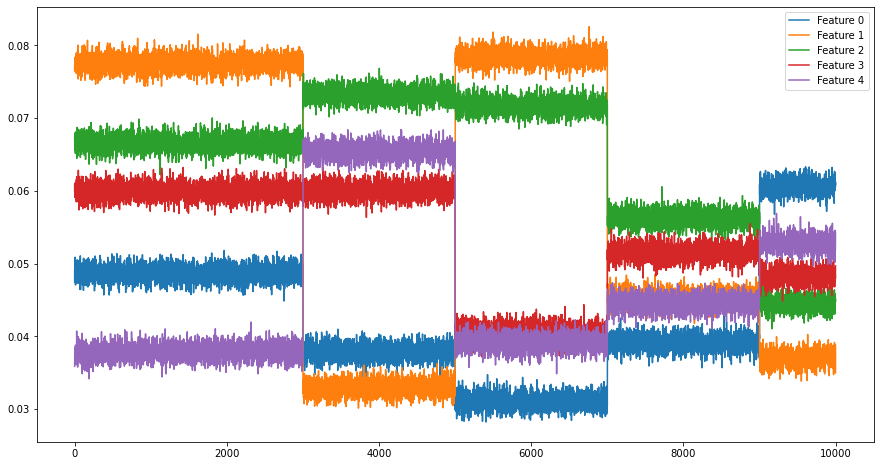

In [34]:
plotting.costs.plot_costs(get_costs(), new_contexts.shape[0])

In [35]:
costs_obj = get_costs()

In [36]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [37]:
costs_vector.shape

(10000, 5)

Compute variables needed for the Oracle policy.

In [38]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))
all_stationarity_regions = [(l, r) for l,r in zip(all_change_point_values, all_change_point_values[1:])]
N_STATIONARY_PERIODS = len(all_stationarity_regions)

cost_means = np.zeros((N_STATIONARY_PERIODS, costs_vector.shape[1]))
for reg_num, region in enumerate(all_stationarity_regions):
    region_costs = costs_vector[slice(*region)]
    cost_means[reg_num, :] = region_costs.mean(axis=0)

# 2 Evaluating bandit algorithms <a class="anchor" id="2-evaluating-bandit-algorithms"></a>

Set the parameters for the experiments.

In [39]:
NUM_OF_TRIALS = all_contexts.shape[0] 
NUM_REPETITIONS = 5

Configure algorithms for which we run the evaluation. Here we also set the hyperparameters.

In [40]:
# Objects in this dict are callables. They generate a new policy object each time they are called.
policy_generators = {
    'Random': lambda: algorithms.RandomPolicy(),
    
    r'$\epsilon$-greedy': lambda: algorithms.EpsilonGreedy(epsilon=0.03, n_arms=new_rewards.shape[1]),
    
    'UCB1': lambda: algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=new_rewards.shape[1],
        alpha=0.6,
    ),
    
    'LinUCB': lambda: algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
    ),
    
    'PS-LinUCB': lambda: algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.05,
    ),
    
    'Sim-OOS': lambda:  algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_num_observations=new_contexts.shape[1],
        delta=0.8,
    ),
    
    'NCC-UCRL2': lambda: algorithms.Algorithm1(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_num_observations=new_contexts.shape[1],
        delta=0.04,
        window_length=250,
        costs_range=COSTS_RANGE_SIZE,
    ),
    
    'Oracle': lambda: algorithms.Algorithm1_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_means=cost_means,
        stationarity_periods=all_stationarity_regions,
        number_of_actions=new_rewards.shape[1],
        max_num_observations=new_contexts.shape[1],
    ),
    
    
}

Run each algorithm `NUM_REPETITIONS` times, gather valuable metrics, average them.

In [41]:
results = {}

for policy_name, policy_generator in policy_generators.items():
    print(f"\tStarting {policy_name} evaluation")
    policy_results = results[policy_name] = {}
    
    policy_results['gains'] = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
    policy_results['rewards'] = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
    policy_results['costs'] = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
    policy_results['arms'] = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
    policy_results['objects'] = []
    
    for i in range(NUM_REPETITIONS):
        policy = policy_generator()
        gain, reward, cost, arms = evaluation.evaluate_on_synthetic_data(
            policy,
            new_contexts,
            new_rewards,
            costs_vector,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        policy_results['gains'][i, :] = gain
        policy_results['rewards'][i, :] = reward
        policy_results['costs'][i, :] = cost
        policy_results['arms'][i, :] = arms
        policy_results['objects'].append(policy)
    
    policy_results['gain'] = np.mean(policy_results['gains'], axis=0)
    policy_results['reward'] = np.mean(policy_results['rewards'], axis=0)
    policy_results['cost'] = np.mean(policy_results['costs'], axis=0)
    print(f"\t{policy_name}, Average gain: {policy_results['gain'][-1]:.2f}")
    print("_"*100 + "\n")
    

	Starting Random evaluation
Random policy
Beta = 1.0
Total gain: 3364.0
	Total reward: 3364.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1.0
Total gain: 3333.0
	Total reward: 3333.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1.0
Total gain: 3284.0
	Total reward: 3284.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1.0
Total gain: 3301.0
	Total reward: 3301.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1.0
Total gain: 3405.0
	Total reward: 3405.0
	Total cost: 0
Execution time: 0.1s
	Random, Average gain: 3337.40
____________________________________________________________________________________________________

	Starting $\epsilon$-greedy evaluation
E-greedy(epsilon=0.03)
Beta = 1.0
Total gain: 3796.0
	Total reward: 3796.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1.0
Total gain: 3816.0
	Total reward: 3816.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1.0
Total gain: 4161.0
	Total reward: 

Round 2000, time 2022-06-28 20:03:28.240781
Round 3000, time 2022-06-28 20:05:42.761718
Round 4000, time 2022-06-28 20:07:56.419622
Round 5000, time 2022-06-28 20:10:10.143399
Round 6000, time 2022-06-28 20:12:23.352866
Round 7000, time 2022-06-28 20:14:37.495087
Round 8000, time 2022-06-28 20:16:50.736501
Round 9000, time 2022-06-28 20:19:04.355083
Algorithm1 (beta=1.0, delta=0.04, w=250)
Beta = 1.0
Total gain: 7534.242368200914
	Total reward: 8442.0
	Total cost: 907.7576317990957
Execution time: 22.2m
Round 0, time 2022-06-28 20:21:18.186596
Round 1000, time 2022-06-28 20:23:27.235015
Round 2000, time 2022-06-28 20:25:42.790462
Round 3000, time 2022-06-28 20:27:56.578165
Round 4000, time 2022-06-28 20:30:11.206872
Round 5000, time 2022-06-28 20:32:24.737902
Round 6000, time 2022-06-28 20:34:38.478440
Round 7000, time 2022-06-28 20:36:52.208691
Round 8000, time 2022-06-28 20:39:05.333890
Round 9000, time 2022-06-28 20:41:18.622534
Algorithm1 (beta=1.0, delta=0.04, w=250)
Beta = 1.0
To

# 3 Plotting figures <a class="anchor" id="3-plotting-figures"></a>

Cumulative gain of each policy.

In [42]:
gains = {p_name:results[p_name]['gain'] for p_name in results if p_name != 'Oracle'}

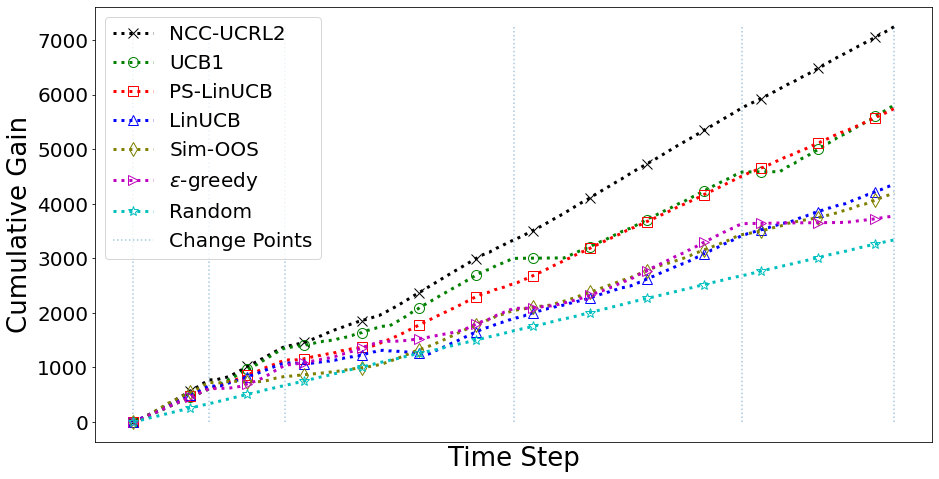

In [43]:
plotting.gains.plot_gains(
    gains,
    reward_change_points=change_point_values,
    cost_change_points=cost_change_points,
)


## 3.1 Regret <a class="anchor" id="3-1-regret"></a>

Plot instantaneous regret of each policy. Instantaneous regret is defined as instantaneous gain of Oracle minus instantaneous gain of given policy at each time step.

In [44]:
regrets = {p_name:results['Oracle']['gain'] - gains[p_name] for p_name in gains}

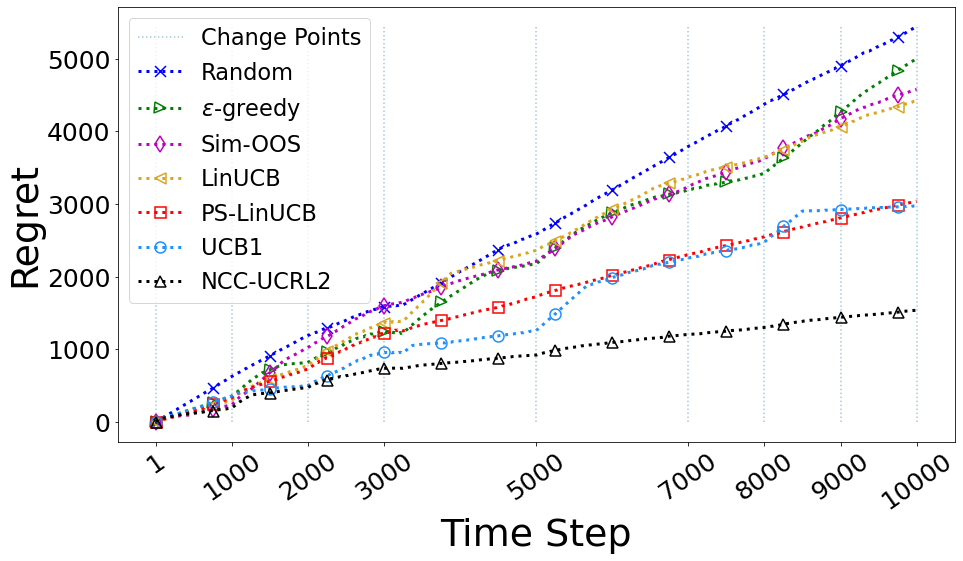

In [45]:
plotting.regrets.plot_regrets(
    regrets,
    reward_change_points=all_change_point_values,
    cost_change_points=all_change_point_values,
    all_change_point_values=all_change_point_values,
)


## 3.2 Reward-cost barchart <a class="anchor" id="3-2-reward-cost-barchart"></a>

Plot the barchart of total accumulated rewards, costs and gains for each policy. This helps better understand the  proportions between them.

In [46]:
gains_by_alg = {p_name:results[p_name]['gain'] for p_name in results}
rewards_by_alg = {p_name:results[p_name]['reward'] for p_name in results}
costs_by_alg = {p_name:results[p_name]['cost'] for p_name in results}

labels = sorted(gains_by_alg.keys(), key=lambda x: gains_by_alg[x][-1], reverse=True)

final_rewards = [rewards_by_alg[label][-1] for label in labels]
final_costs = [costs_by_alg[label][-1] for label in labels]
final_gains = [gains_by_alg[label][-1] for label in labels]

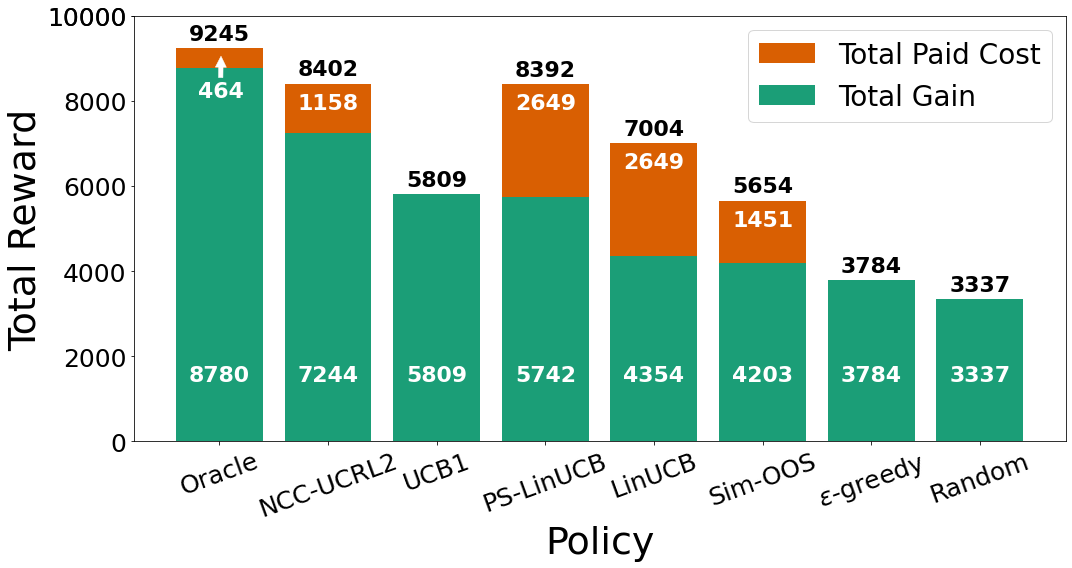

In [47]:
plotting.reward_cost_barchart.plot_reward_cost_barchart(
    labels, final_rewards, final_costs, final_gains,
)

## 3.3 Arm selection histogram <a class="anchor" id="3-3-arm-selection-histogram"></a>

Compare the arm choices of Oracle, NCC-UCRL2 and UCB1 policies. Matching the pattern of the Oracle corresponds to better performance.

In [48]:
histograms = {
    p_name: np.mean(
        [algorithms.utilities.get_histograms(arms, all_stationarity_regions) for arms in results[p_name]['arms']],
        axis=0,
    )
    for p_name in results
}

N_STATIONARY_PERIODS = len(all_stationarity_regions)
algs_to_plot = ["Oracle", "NCC-UCRL2", "UCB1"]
colors = ['cyan', 'red', 'blue']

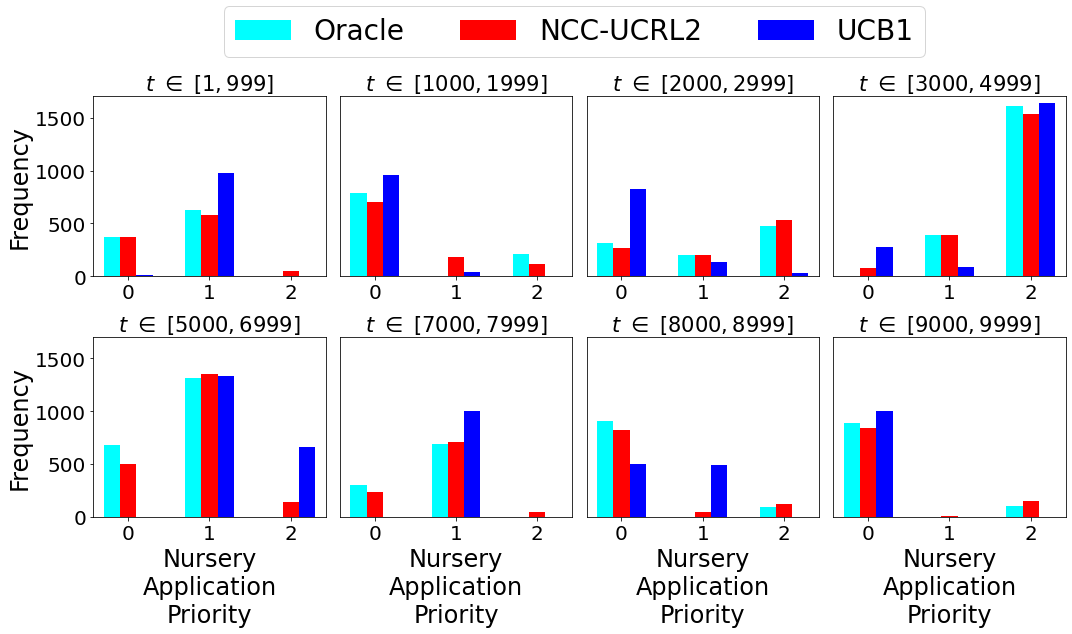

In [49]:
plotting.histogram.plot_histogram(
    histograms, all_stationarity_regions, algs_to_plot, colors, N_STATIONARY_PERIODS
)

## 3.4 Accuracy <a class="anchor" id="3-4-accuracy"></a>

We define accuracy when up to $l$ observations are made as
$
(\sum_{j=0}^{l}{\sum_{t=1}^{T}{r_t \mathbb{1}\{|I_t| = j \}}}) / 
(\sum_{j=0}^{l}{\sum_{t=1}^{T}{\mathbb{1}\{|I_t| = j \}}})
$.
We call this Accuracy because receiving reward 1 corresponds to correctly classifying a nursery application. This illustrates how observing more features marginally affects the performance of the algorithms.

In [50]:
accuracies = {
    "NCC-UCRL2": np.mean(
        np.stack([algorithms.utilities.get_accuracy(ncc) for ncc in results["NCC-UCRL2"]["objects"]]),
        axis=0
    ),
    "Sim-OOS": np.mean(
        np.stack([algorithms.utilities.get_accuracy(simoos) for simoos in results["Sim-OOS"]["objects"]]),
        axis=0
    ),
} 

    

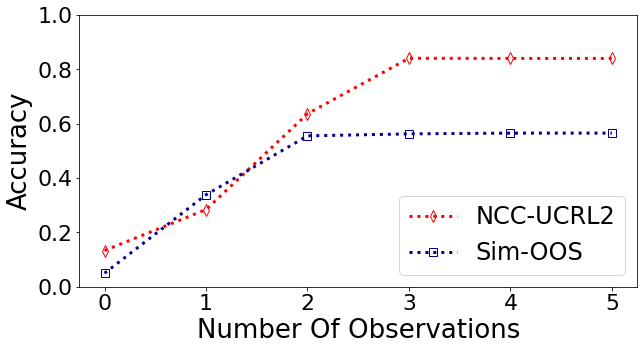

In [51]:
plotting.accuracy.plot_accuracy(accuracies)